#Pokemon Usage Statistics: 

###An In-Depth Analysis of the ORAS OU Metagame

In [188]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from datetime import datetime
import sqlite3
from pprint import pprint
import matplotlib.pyplot as plt

Lets mine the last 3 months of data from [Smogon](www.smogon.com)! For those of you who don't play pokemon competitively, Smogon is the hub of the competitive community, that collects data from the equally awesome [Pokemon Showdown](pokemonshowdown.com). Shouts out to both of these communities and the work that they do for the world of competitive pokemon!

In [140]:
year = datetime.now().year
month = datetime.now().month

In [267]:
def get_usage(year, month):
    '''This function scapes Smogon for '''
    y = str(year)
    m = '0' + str(month)
    url = 'http://www.smogon.com/stats/' + y + '-' + m + '/ou-1500.txt'
    page = str(requests.get(url).text)
    # clean it up so we can import it 
    lines = page.split('\n')
    del lines[0:3]
    del lines[1]
    lines = lines[:50]
    filename = y + m +' pokes.csv'
    with open(filename, 'w') as f:
        for line in lines:
            csv_line = line.replace('|', ',').replace(' ', '')[1:] + '\n' 
            f.write(csv_line)
    df = pd.read_csv(filename)
    df = df.drop('Unnamed: 7',1).drop('Raw', 1).drop('Real', 1).drop('%', 1).drop('%.1', 1)
    df['Month'] = datetime.strptime(m, '%m').month
    df['Usage%'] = [float(df['Usage%'][i].replace('%', '')) for i in df.index]
    return df.copy(deep=True)

In [268]:
dfs_2015 = [get_usage(2015, i) for i in range(month-3, month)]
pokemon_2015 = pd.concat(i for i in dfs_2015)

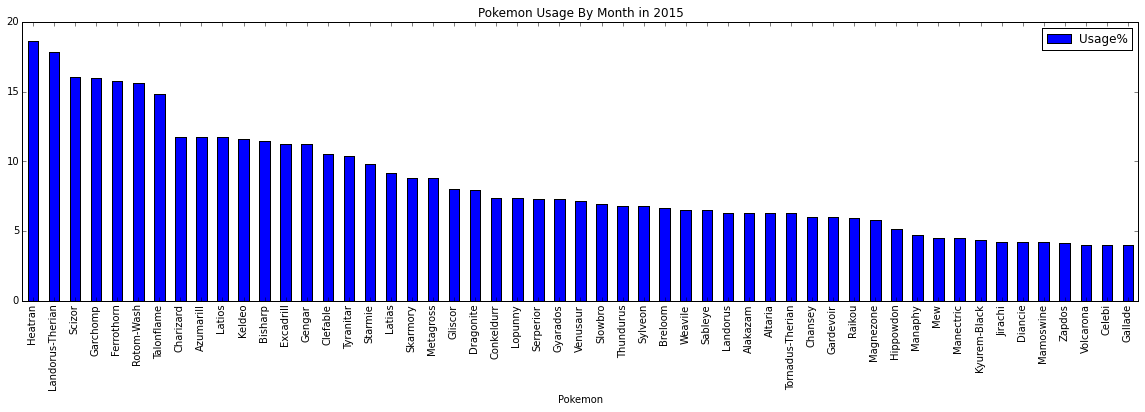

In [269]:
%matplotlib inline
mean_usage = pd.DataFrame(pokemon_2015.groupby(['Pokemon'])['Usage%'].mean())
mean_usage.sort(['Usage%'], ascending=[0]).plot(kind='bar', figsize=(20,5), title='Pokemon Usage By Month in 2015')

Cool. That's just a basic representation of how used these pokemon are over the last couple of months. What if we could get deeper? What if we tested the correlation between the usage rates of pokemon? For instance, does the usage of Heatran rise (as expected) with the usage of Latias or Ferrothorn? Lets get some more data for last 6 months!

In [271]:
import statsmodels.api as sm
dfs_2015 = [get_usage(2015, i) for i in range(1, month)]
pokemon_2015 = pd.concat(i for i in dfs_2015)
pokemon_2015 = pokemon_2015.set_index('Pokemon')

Lets use Heatran, Latias and Ferrothorn as examples:

In [289]:
print(pokemon_2015.loc['Heatran'])
print(pokemon_2015.loc['Latias'])
print(pokemon_2015.loc['Ferrothorn'])
print(pokemon_2015.loc['Scizor'])
print(pokemon_2015.loc['Azumarill'])

         Rank    Usage%  Month
Pokemon                       
Heatran     3  18.31457      1
Heatran     2  18.36472      2
Heatran     2  18.07531      3
Heatran     1  18.72977      4
Heatran     1  18.52988      5
Heatran     1  18.56961      6
         Rank    Usage%  Month
Pokemon                       
Latias     14  10.56474      1
Latias     17   9.76697      2
Latias     18   9.03375      3
Latias     19   8.98918      4
Latias     18   9.37628      5
Latias     18   9.07131      6
            Rank    Usage%  Month
Pokemon                          
Ferrothorn     4  17.31039      1
Ferrothorn     4  16.95703      2
Ferrothorn     5  15.98774      3
Ferrothorn     3  17.07091      4
Ferrothorn     6  15.36196      5
Ferrothorn     6  14.83029      6
         Rank    Usage%  Month
Pokemon                       
Scizor      8  13.17432      1
Scizor      6  13.60962      2
Scizor      6  15.45723      3
Scizor      5  15.73311      4
Scizor      4  15.67490      5
Scizor      4  

In [292]:
y = pokemon_2015.loc['Ferrothorn']['Rank'].tolist()
x = pokemon_2015.loc['Azumarill']['Rank'].tolist()
model = sm.OLS(y,x)
results = model.fit()
results.summary()

([4, 4, 5, 3, 6, 6], [9, 9, 8, 11, 13, 8])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     55.65
Date:                Fri, 10 Jul 2015   Prob (F-statistic):           0.000683
Time:                        14:53:18   Log-Likelihood:                -10.433
No. Observations:                   6   AIC:                             22.87
Df Residuals:                       5   BIC:                             22.66
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.4672      0.063      7.460      0.001         0.306     0.628
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   2.061
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.122
Skew:                          -0.085   Prob(JB):                        0.941
Kurtosis:                       2.324   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""